**Part 1: Generating stories on pretained GPT2 from Hugging Face (with personal finetuning).**

In [ ]:
!pip install transformers

In [ ]:
# Installing important libraries
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import torch.nn.functional as F
import csv
import re

In [ ]:
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device("cpu")
print(f"Using {device_name}")
device = device_name

Using cuda


Link to kaggle dataset: https://www.kaggle.com/datasets/edenbd/children-stories-text-corpus. I found this corpus to combine a lot of different SEPERATE datasets I found on kaggle into one textfile. The textfile combines about three styles of data. 1. HISTORICAL Classics (with authors like Austen, Dickens, and Shakespeare). 2. MODERN gothic folktales from various cultures (this added more variation with language and diction. There are folktales from India, Italy, Japan, etc.). 3. Children's stories (more fantasy like Peter Pan, Wizard of Oz, etc.), and children's textbooks (A Supplementary Reader for the Fourth Year of School, Wonder Stories, etc.)

In [ ]:
import requests

# Code from: https://ericmjl.github.io/blog/2023/4/11/how-to-programmatically-download-a-file-from-dropbox-without-the-dropbox-api/
headers = {'user-agent': 'Wget/1.16 (linux-gnu)'}
r = requests.get("https://www.dropbox.com/scl/fi/vvh9zjiqhrgnadlz5qneu/storyTextData.txt?rlkey=2o41bf8j73ig59h1nvllhor71&st=gw8ots67&dl=0", stream=True, headers=headers)
storyData = "storyTextData.txt"

with open(storyData, 'wb') as f:
    f.write(r.content)

In [ ]:
# Preprocessing the data

STORIES = {}
AUTHORS = ['EDWARD LEAR', 'ISAAC WATTS', 'JANE TAYLOR', 'PHOEBE CARY', 'ANN TAYLOR', 'ANONYMOUS', 'CHARLES KINGSLEY', 'CHARLES MACKAY', 'CLEMENT CLARKE MOORE', 'DAVID EVERETT', 'ELIZA LEE FOLLEN', 'FELICIA DOROTHEA HEMANS', 'FELICIA DOROTHEA HEMANS', 'FELICIA DOROTHEA HEMANS', 'FRANCIS C. WOODWORTH', 'FROM M. DE LAMOTTE', 'GEORGE MACDONALD', 'HANNAH FLAGG GOULD', 'HENRY WADSWORTH LONGFELLOW', 'JAMES HOGG', 'JAMES MERRICK',
                'JAMES WHITCOMB RILEY', 'JANE TAYLOR', 'JEMIMA LUKE', 'LEWIS CARROLL', 'LITTLE B. (TAYLOR?)', 'LYDIA MARIA CHILD', 'MARY HOWITT', 'MARY HOWITT', 'MARY HOWITT', 'OLD CAROL', 'REGINALD HEBER', 'RICHARD MONCKTON MILNES (LORD HOUGHTON)', 'ROBERT BURNS', 'ROBERT LOUIS STEVENSON', 'ROBERT SOUTHEY', 'SABINE BARING-GOULD', 'THOMAS HOOD', 'WILLIAM BRIGHTY RANDS', 'WILLIAM HOWITT', 'WILLIAM ROBERT SPENCER', 'WILLIAM SHAKESPEARE', 'WILLIAM WORDSWORTH']
STYLES = ['SCANDINAVIAN STORIES', 'GERMAN STORIES', 'FRENCH STORIES', 'ENGLISH STORIES','CELTIC STORIES', 'ITALIAN STORIES', 'JAPANESE STORIES', 'EAST INDIAN STORIES', 'AMERICAN INDIAN STORIES', 'ARABIAN STORIES', 'CHINESE STORIES', 'RUSSIAN STORIES', 'TALES FOR TINY TOTS', 'FANCIFUL STORIES', 'OUR CHILDREN', 'PINOCCHIO\'S ADVENTURES IN WONDERLAND[1]']

# the following function opens the storyData, and reads it, extracts the first line to initialize the cTitle variable, Loops through the lines, skipping the first one, Cleans each line by removing unnecessary spaces and tabs.
# filters out lines with the title story type, or author's name, Converts the list of story lines into a single string for each story title, etc.
# Skeletal code: https://stackoverflow.com/questions/58093426/train-gpt-2-on-local-machine-load-dataset
def processText():
    with open(storyData, "r") as f:
        lines = f.readlines()
        firstLine = lines[0].strip(" \n")
        cTitle = re.sub('[\t]+', '', firstLine).upper()

        for i in range(1, len(lines) - 1):
            line = lines[i].strip(" \n")
            line = re.sub('[\t]+', '', line)  # to remove tabs
            line = re.sub("        ", '', line)
            if len(line) == 0 or (line in AUTHORS) or (line in STYLES) or ("ADAPTED BY" in line):
                continue

            elif (line in ["CINDERELLA", "BLUE BEARD", "SUPPOSE!", "PRETTY COW", "THE OWL AND THE PUSSY-CAT"]):
                cTitle = line
                STORIES[cTitle] = []

            # link: https://stackoverflow.com/questions/31661307/python-regex-remove-n
            if (line == '\n' or len(line) < 3) and len(lines[i+1]) < 50:
                upcoming_title = lines[i+1].strip(" \n")
                cTitle = re.sub('[\t]+', '', upcoming_title).upper()

            elif (line[0].isnumeric()):
                cTitle = line.upper()
                STORIES[cTitle] = []

            #link: https://stackoverflow.com/questions/56063750/how-to-have-the-isupper-and-islower-methods-in-one-line-of-code
            elif (line.isupper() and ("ADAPTED BY" in lines[i+1] or "BY " in lines[i+1])):
                cTitle = line
                STORIES[cTitle] = []

            elif (line.isupper() and " STORY" in lines[i+1]):
                first_sentence = lines[i+1].split()
                if "--" in cTitle:
                    # replacing with next chapter
                    cTitle = cTitle.split(
                        " --", 1)[0] + " --" + ' '.join(first_sentence[0:2])
                else:
                    cTitle = line + " --" + ' '.join(first_sentence[0:2])

                STORIES[cTitle] = [' '.join(first_sentence[2:])]

            elif (" STORY" in line or " Story." in line) and not ("OF" in line and not (" STORY" in lines[i+1])):
                first_sentence = line.split()
                if "--" in cTitle:
                    # replacing with next chapter
                    cTitle = cTitle.split(
                        " --", 1)[0] + " --" + ' '.join(first_sentence[0:2])
                else:
                    cTitle = cTitle + " --" + \
                        ' '.join(first_sentence[0:2])

                begin_story = [' '.join(first_sentence[2:])]
                if len(begin_story) <= 1:
                    STORIES[cTitle] = []
                else:
                    STORIES[cTitle] = [' '.join(first_sentence[2:])]

            elif (line.isupper()) and not (str(lines[i+1].split()[0:2]).isupper() or ("THE END" in line) or ("\"" in line) or ("“" in line) or ("\'" in line) or ("{" in line) or (line in "TRESPASSERS WILL BE PROSECUTED") or (line in "FAMOUS DONKEY THE STAR OF THE DANCE") or ("ADAPTED BY" in line) or (line in "* A.D. 1482-1513")):
                if (len(line) >= 11 and len(line) < 50):
                    cTitle = line.upper()
                    STORIES[cTitle] = []

                elif (len(line) < 11 and len(line) < 50) or (line in "CHAPTER"):
                    if "--" in cTitle:
                        # replace with next chapter
                        cTitle = cTitle.split(
                            " --", 1)[0] + " --" + line
                    if not (line in cTitle):
                        cTitle = cTitle + " --" + line
                    STORIES[cTitle] = []

            elif (cTitle in STORIES) and (line.upper() != cTitle):
                STORIES[cTitle].append(line)
            else:
                STORIES[cTitle] = []

    # Removing extra titles that the system did not get fed on.
    STORIES_COPY = STORIES.copy()
    for story in STORIES_COPY:
        if STORIES[story] == []:
            STORIES.pop(story)

    # Making each story in the dictionary a full string so that it matches the tutorial's format
    for title in STORIES:
        STORIES[title] = ' '.join(STORIES[title])

processText()

This creates the valid stories that we will be using for training. Stories that are too short are not going to be used (I experimented with this, and they make the final generation very repetitive due to overfitting).

In [ ]:
valStories = []
for key, value in STORIES.items():
    #length must be at least 600 characters.
  if len(value) >= 600:
    valStories.append(value)
STORIES = {}

modelData = len(valStories)

In [ ]:
import random

# Breaking up the model data set for training, validating, and testing.
# code: https://www.kaggle.com/code/tuckerarrants/text-generation-with-huggingface-gpt2
training_set_size = int(modelData * 0.7)
validation_set_size = int(modelData * 0.1)
testing_set_size = int(modelData * 0.2)

# ensures replication of results
random.seed(46)

random.shuffle(valStories)

training_set = valStories[:training_set_size]
validation_set = valStories[training_set_size:training_set_size + validation_set_size]
testing_set = valStories[training_set_size + validation_set_size:]

In [ ]:
# Dataset comes from torch.utils.data
# code: https://www.kaggle.com/code/tuckerarrants/text-generation-with-huggingface-gpt2
class Stories(Dataset):
    def __init__(self, control_code, truncate=False, gpt2_type="gpt2", max_length=1024):
        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        self.stories = []

        # reference: https://huggingface.co/docs/transformers/main/en/internal/tokenization_utils
        # https://github.com/huggingface/transformers/issues/2026
        for story in control_code:
          self.stories.append(torch.tensor(
                self.tokenizer.encode(f"<|startoftext|>{story}<|endoftext|>")[:max_length]
            ))
        if truncate:
            self.stories = self.stories[:20000]
        self.stories_count = len(self.stories)
    def __len__(self):
        return self.stories_count

    def __getitem__(self, item):
        return self.stories[item]

In [ ]:
dataset = Stories(training_set, truncate=True, gpt2_type="gpt2")
val_dataset = Stories(validation_set, truncate=True, gpt2_type="gpt2")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1280 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9491 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
#The tokenizer and model, as well as conversion to tensors
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

#handles input tensors for batching, ensuring that the total sequence length does not exceed a specified maximum.
# This portion of the code was inspired by: https://github.com/falloutdurham/beginners-pytorch-deep-learning/blob/master/chapter9/Chapter9.5.ipynb
# https://github.com/francoisstamant/lyrics-generation-with-GPT2/blob/main/GPT2_final.ipynb
def pack_tensor(new_tensor, packed_tensor, max_seq_len):
    if packed_tensor is None:
        return new_tensor, True, None
    if new_tensor.size()[1] + packed_tensor.size()[1] > max_seq_len:
        return packed_tensor, False, new_tensor
    else:
        packed_tensor = torch.cat([new_tensor, packed_tensor[:, 1:]], dim=1)
        return packed_tensor, True, None

Calculating the loss function during training, and loading in the checkpoint_path. The checkpoint stores the model's learned parameters (weights & biases), enabling you to save the model at specific stages of training. Adding this to the training helped the model to be reloaded later for inference.

In [ ]:
import requests
# calculate the loss of a language model on a validation dataset. This will be used during training to plot the loss during training.
# https://stackoverflow.com/questions/75710776/huggingface-gpt2-loss-understanding
def calc_val_loss(validation_set, model):
    model.eval()
    device=device_name
    with torch.no_grad():
      val_dataloader = DataLoader(validation_set, batch_size=1)
      loss = 0

      input_tensor = None
      for idx, entry in tqdm(enumerate(val_dataloader)):
          entry = entry.to(device)
          (input_tensor, carry_on, remainder) = pack_tensor(entry, input_tensor, 768)
          if carry_on and idx != len(val_dataloader) - 1:
              continue

          input_tensor = input_tensor.to(device)
          outputs = model(input_tensor, labels=input_tensor)

          loss = outputs[0]
    return loss

# ericmjl.github.io/blog/2023/4/11/how-to-programmatically-download-a-file-from-dropbox-without-the-dropbox-api/
headers = {'user-agent': 'Wget/1.16 (linux-gnu)'}
r = requests.get("https://www.dropbox.com/scl/fi/9743m8g3klog0hes5jcuw/transformerRef.pt?rlkey=qkblzl5wbgkub00a0evlj8ld9&st=gr5cmmx4&dl=0", stream=True, headers=headers)

checkpoint_path = "transformerRef.pt"
checkpoint2_latest = "transformerRef.pt"
with open(checkpoint_path, 'wb') as f:
    f.write(r.content)

with open(checkpoint2_latest, 'wb') as f:
    f.write(r.content)

In [ ]:
# Checking if the dataset is non-empty
print(f"Training dataset size: {len(dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Checks the first batch of the training dataset
train_loader = DataLoader(dataset, batch_size=2)
for batch in train_loader:
    print("First batch:", batch)
    break

Training dataset size: 1013
Validation dataset size: 144
First batch: tensor([[   27,    91,  9688,  ...,  3290,   290,   262],
        [   27,    91,  9688,  ...,  8522,   321, 10137]])


In [ ]:
# code inspired by: https://github.com/francoisstamant/lyrics-generation-with-GPT2/blob/main/GPT2_final.ipynb
def train(
    dataset, model, tokenizer,
    batch_size=4, epochs=2, lr=2e-5,
    max_seq_len=400, warmup_steps=200, test_mode=False, validation_set=None
):
    acc_steps = 100
    device=device_name
    model = model.cuda()

    optimizer = AdamW(model.parameters(), lr=lr)

    train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    loss=0
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    accumulating_batch_count = 0
    input_tensor = None

    for epoch in range(epochs):
        if validation_set:  # also recording initial validation loss for progress
            print("about to start validating")
            val_loss = calc_val_loss(validation_set, model)
            val_losses.append(val_loss.item())

            if val_loss < best_val_loss:
              print("saving new model")
              best_val_loss = val_loss
              torch.save(model.state_dict(), checkpoint_path)

            # also save latest model, we might like some overfitting
            torch.save(model.state_dict(), checkpoint2_latest)

        print(f"Training epoch {epoch}")

        running_training_loss = 0
        data_points = 0
        model.train()
        for idx, entry in tqdm(enumerate(train_dataloader)):
            (input_tensor, carry_on, remainder) = pack_tensor(entry, input_tensor, 768)

            if carry_on and idx != len(train_dataloader) - 1:
                continue

            input_tensor = input_tensor.to(device)
            outputs = model(input_tensor, labels=input_tensor)
            loss = outputs[0]
            data_points += 1
            running_training_loss += loss.item()
            loss.backward()

            if (accumulating_batch_count % batch_size) == 0:
                optimizer.step()
                # scheduler.step()
                optimizer.zero_grad()
                model.zero_grad()

            accumulating_batch_count += 1
            input_tensor = None

        train_losses.append(running_training_loss / data_points)

    return model, ([i for i in range(epochs)], train_losses, val_losses)

In [ ]:
# Training for model.
model, plot_info = train(dataset, model, tokenizer, epochs=15, validation_set=val_dataset)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


about to start validating


144it [00:07, 19.74it/s]


saving new model
Training epoch 0


1013it [01:39, 10.21it/s]


about to start validating


144it [00:07, 20.45it/s]


saving new model
Training epoch 1


1013it [01:39, 10.19it/s]


about to start validating


144it [00:07, 20.32it/s]


saving new model
Training epoch 2


1013it [01:39, 10.16it/s]


about to start validating


144it [00:07, 20.50it/s]


saving new model
Training epoch 3


1013it [01:38, 10.29it/s]


about to start validating


144it [00:07, 20.53it/s]


saving new model
Training epoch 4


1013it [01:38, 10.29it/s]


about to start validating


144it [00:07, 20.07it/s]


Training epoch 5


1013it [01:38, 10.31it/s]


about to start validating


144it [00:07, 20.09it/s]


saving new model
Training epoch 6


1013it [01:38, 10.30it/s]


about to start validating


144it [00:07, 20.44it/s]


Training epoch 7


1013it [01:38, 10.34it/s]


about to start validating


144it [00:07, 20.49it/s]


saving new model
Training epoch 8


1013it [01:38, 10.24it/s]


about to start validating


144it [00:07, 20.08it/s]


Training epoch 9


1013it [01:38, 10.28it/s]


about to start validating


144it [00:07, 20.37it/s]


Training epoch 10


1013it [01:39, 10.18it/s]


about to start validating


144it [00:07, 20.07it/s]


Training epoch 11


1013it [01:39, 10.16it/s]


about to start validating


144it [00:07, 20.30it/s]


Training epoch 12


1013it [01:39, 10.17it/s]


about to start validating


144it [00:07, 20.25it/s]


Training epoch 13


1013it [01:41, 10.03it/s]


about to start validating


144it [00:07, 20.50it/s]


Training epoch 14


1013it [01:38, 10.23it/s]


Training:  [3.3057964733260836, 3.2408670703332105, 3.197889561424712, 3.140255190817958, 3.122912970736297, 3.1352775617100845, 3.063646176540519, 3.0398706126213075, 3.020977286410853, 2.983114286753577, 2.996546500036032, 2.9643725547828446, 2.94128561670345, 2.918012248567376, 2.9017988153662815]
Validation: [3.249417781829834, 3.111604690551758, 3.096909523010254, 3.0844533443450928, 3.0795793533325195, 3.0824296474456787, 3.078843832015991, 3.0790092945098877, 3.059495687484741, 3.0835580825805664, 3.080496311187744, 3.080228328704834, 3.0816023349761963, 3.0894789695739746, 3.083314895629883]


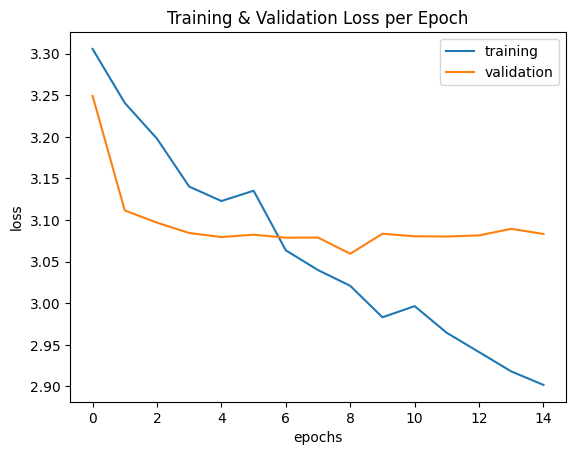

In [ ]:
# plotting loss: https://machinelearningmastery.com/plotting-the-training-and-validation-loss-curves-for-the-transformer-model/
# As shown in the graph, as the epoch trains, the loss decreases.
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
def plot_training_curve(epochs, train_losses, valid_losses):

    print("Training: ", train_losses)
    print("Validation:", valid_losses)
    # Training plot
    plt.title("Training & Validation Loss per Epoch")
    plt.plot(epochs, train_losses, label="training")
    plt.plot(epochs, valid_losses, label="validation")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

plot_training_curve(*plot_info)

link to reference code: https://huggingface.co/docs/transformers/en/model_doc/gpt2

In [ ]:
# Loads the checkpoint
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model2 = GPT2LMHeadModel.from_pretrained('gpt2', force_download=True)

# Loads the saved state dict with safe device mapping
saved_state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))
# Loads the state dictionary with strict=False
model2.load_state_dict(saved_state_dict, strict=False)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/tmp/ipykernel_30/1291664459.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))


<All keys matched successfully>

Fine-tuning GPT2 model: https://huggingface.co/transformers/v2.11.0/main_classes/tokenizer.html.
Parameters I focused on were top_p, and temperature. Overall, increasing temperature above 0.9 make the final output more  incoherent and random. As for top_p, lower values (I tried 0.3 to 0.6) made the story much more repetitive. There was no clear beginning, middle or end.


In [ ]:
def tell_a_tale(prompt, model, min_length=50, max_length=200, top_p=0.8, temperature=0.9):
    inputs = tokenizer.encode(prompt, return_tensors="pt")
    outputs = model.generate(
        inputs,
        do_sample=True,
        min_length=min_length,
        max_length=max_length,
        top_p=top_p,
        temperature=temperature,
        pad_token_id=tokenizer.eos_token_id
    )
    completed_story = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return completed_story

To quantatively test the story generation for GPT2, I used the BLEU metric. While the BLEU metric is mainly used for machine translation, and is not a great metric for story generation (which is more creative), BLEU measures the literal word accuracy. BLEU also compares the reference text with the text the model is generating. For my model, I got a BLEU score of approximately 14%. It does not really mean anything in terms of success of my model, but I interpreted it as varying more in writing, and hence a bit more creative. However, the BLEU score matters less since it is more precision focused, which is not as important when it comes to story generation! The next metric is much more useful!

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np
smoothie = SmoothingFunction().method4

# BLEU scoring: https://stackoverflow.com/questions/73835778/bleu-score-in-nltk-library
# https://towardsdatascience.com/how-to-evaluate-text-generation-models-metrics-for-automatic-evaluation-of-nlp-models-e1c251b04ec1
scores = []

max_stories_to_score = 60

for i, story in enumerate(testing_set):
    if i >= max_stories_to_score:
        break  # Stop after processing 'max_stories_to_score' stories

    story_words = story.split(' ')
    story_words = story_words[:100]   # Evaluate initial part of story

    words_for_completion = 30
    prompt = story_words[:-words_for_completion]
    start = ' '.join(prompt)
    completion = story_words[-words_for_completion:]
    end = ' '.join(completion)

    candidate = tell_a_tale(start, model2, min_length=100, max_length=300)
    canadidate_list = candidate.split(' ')
    print("Candidate is: ", canadidate_list)
    print("story is: ", story_words)

    score = sentence_bleu(story_words, canadidate_list, smoothing_function=smoothie)
    print("Score is: ", score)
    scores.append(score)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Candidate is:  ['Sitting', 'patient', 'in', 'the', 'shadow', '', '', '', '', 'Till', 'the', 'blessed', 'light', 'shall', 'come,', '', '', '', '', 'A', 'serene', 'and', 'saintly', 'presence', '', '', '', '', 'Sanctifies', 'our', 'troubled', 'home.', 'Earthly', 'joys', 'and', 'hopes', 'and', 'sorrows', '', '', '', '', 'Break', 'like', 'ripples', 'on', 'the', 'strand', '', '', '', '', 'Of', 'the', 'deep', 'and', 'solemn', 'river', '', '', '', '', 'Where', 'her', 'willing', 'feet', 'now', 'stand.', 'O', 'my', 'child,', 'Earthly', 'joys', '', '', '', '', '', 'My', 'mother', 'and', 'father', '', '', '', '', '', '', '', '', '']
story is:  ['Sitting', 'patient', 'in', 'the', 'shadow', '', '', '', '', 'Till', 'the', 'blessed', 'light', 'shall', 'come,', '', '', '', '', 'A', 'serene', 'and', 'saintly', 'presence', '', '', '', '', 'Sanctifies', 'our', 'troubled', 'home.', 'Earthly', 'joys', 'and', 'hopes', 'and', 'sorrows', '', '', '', '', 'Break', 'like', 'ripples', 'on', 'the', 'strand', '', ''

In [ ]:
print("New score is: ", np.mean(scores))

New score is:  0.14064357467862662


Overall, ROUGE is generally considered a better choice than BLEU when it comes to story generation because ROUGE focuses on capturing the key information and important details of a story (recall-oriented). Since stories often rely on narrative structure and key plot points, ROUGE is better at assessing whether the generated story captures the essential elements of the reference story even if the wording differs slightly. ROUGE also allows for some variation in wording, making it more tolerant of creative language used in story generation.

I use the n-rouge method mentioned in the linked article. I found my rouge scores to be significantly better than my BLEU scores, with a mean of approximately 73%.

In [ ]:
# Code Link: https://towardsdatascience.com/how-to-evaluate-text-generation-models-metrics-for-automatic-evaluation-of-nlp-models-e1c251b04ec1
#rouge scores for a reference/generated sentence pair
#source google seq2seq source code.
import itertools

#supporting function
def _split_into_words(sentences):
  """Splits multiple sentences into words and flattens the result"""
  return list(itertools.chain(*[_.split(" ") for _ in sentences]))

#supporting function
def _get_word_ngrams(n, sentences):
  """Calculates word n-grams for multiple sentences.
  """
  assert len(sentences) > 0
  assert n > 0

  words = _split_into_words(sentences)
  return _get_ngrams(n, words)

#supporting function
def _get_ngrams(n, text):
  """Calcualtes n-grams.
  Args:
    n: which n-grams to calculate
    text: An array of tokens
  Returns:
    A set of n-grams
  """
  ngram_set = set()
  text_length = len(text)
  max_index_ngram_start = text_length - n
  for i in range(max_index_ngram_start + 1):
    ngram_set.add(tuple(text[i:i + n]))
  return ngram_set

def rouge_n(reference_sentences, evaluated_sentences, n=2):
  """
  Computes ROUGE-N of two text collections of sentences.
  Source: http://research.microsoft.com/en-us/um/people/cyl/download/
  papers/rouge-working-note-v1.3.1.pdf
  Args:
    evaluated_sentences: The sentences that have been picked by the summarizer
    reference_sentences: The sentences from the referene set
    n: Size of ngram.  Defaults to 2.
  Returns:
    recall rouge score(float)
  Raises:
    ValueError: raises exception if a param has len <= 0
  """
  if len(evaluated_sentences) <= 0 or len(reference_sentences) <= 0:
    raise ValueError("Collections must contain at least 1 sentence.")

  evaluated_ngrams = _get_word_ngrams(n, evaluated_sentences)
  reference_ngrams = _get_word_ngrams(n, reference_sentences)
  reference_count = len(reference_ngrams)
  evaluated_count = len(evaluated_ngrams)

  # Gets the overlapping ngrams between evaluated and reference
  overlapping_ngrams = evaluated_ngrams.intersection(reference_ngrams)
  overlapping_count = len(overlapping_ngrams)

  # Handle edge case. This isn't mathematically correct, but it's good enough
  if evaluated_count == 0:
    precision = 0.0
  else:
    precision = overlapping_count / evaluated_count

  if reference_count == 0:
    recall = 0.0
  else:
    recall = overlapping_count / reference_count

  f1_score = 2.0 * ((precision * recall) / (precision + recall + 1e-8))

  return recall

In [ ]:
scores = []
max_stories_to_score = 60

for i, story in enumerate(testing_set):
    if i >= max_stories_to_score:
        break  # Stop after processing 'max_stories_to_score' stories

    story_words = story.split(' ')
    story_words = story_words[:100]   # Evaluate initial part of story

    words_for_completion = 30
    prompt = story_words[:-words_for_completion]
    start = ' '.join(prompt)
    completion = story_words[-words_for_completion:]
    end = ' '.join(completion)

    candidate = tell_a_tale(start, model2, min_length=100, max_length=275)
    canadidate_list = candidate.split(' ')
    print("Candidate is: ", canadidate_list)
    print("story is: ", story_words)

    score = rouge_n(story_words, canadidate_list)
    print("Score is: ", score)
    scores.append(score)
    print("Score is: ", np.mean(scores))

Candidate is:  ['Sitting', 'patient', 'in', 'the', 'shadow', '', '', '', '', 'Till', 'the', 'blessed', 'light', 'shall', 'come,', '', '', '', '', 'A', 'serene', 'and', 'saintly', 'presence', '', '', '', '', 'Sanctifies', 'our', 'troubled', 'home.', 'Earthly', 'joys', 'and', 'hopes', 'and', 'sorrows', '', '', '', '', 'Break', 'like', 'ripples', 'on', 'the', 'strand', '', '', '', '', 'Of', 'the', 'deep', 'and', 'solemn', 'river', '', '', '', '', 'Where', 'her', 'willing', 'feet', 'now', 'stand.', 'O', 'my', 'dear', 'children,', '', '', '', '', '', 'And', 'when', 'you', 'come', 'home,', '', '', '', '', 'You', 'will', 'be', 'safe.']
story is:  ['Sitting', 'patient', 'in', 'the', 'shadow', '', '', '', '', 'Till', 'the', 'blessed', 'light', 'shall', 'come,', '', '', '', '', 'A', 'serene', 'and', 'saintly', 'presence', '', '', '', '', 'Sanctifies', 'our', 'troubled', 'home.', 'Earthly', 'joys', 'and', 'hopes', 'and', 'sorrows', '', '', '', '', 'Break', 'like', 'ripples', 'on', 'the', 'strand'

In [ ]:
print("Score is: ", np.mean(scores))

Score is:  0.7146775133183083


Example 1: Testing generated horror story (going for a more modern language style). Note: if you do not get a great story on your first try, running again might help! GPT is often unreliable. Also, being more specific with the story (don't only write one word, like "winter").

In [ ]:
print(tell_a_tale("Hannah went into a scary haunted house, where the floors were", model2, max_length=200))

Hannah went into a scary haunted house, where the floors were all covered with all sorts of little things.  She thought she had seen all kinds of things, but she could not tell if any were real.  Her curiosity grew and grew until she came to a very dark place.  She saw a large tree with a large branch hanging from the trunk.  She climbed up and looked down.  There was nothing but black and white and very dark things in the wood.  She was not surprised to find a lot of blood, but she did not know if it was real.  It was a strange kind of blood.  Hannah had never seen anything like it before. "I should like to know where it is," said Hannah.  "I've seen it a long time." Hannah felt very anxious, and looked at the branch she was climbing up.  She wanted to tell the story. She could not tell how she had come to the tree, but she felt very


Example 2: Testing a more romantic, "classical-historical" writing style.

In [ ]:
print(tell_a_tale("How art thy on this morning", model2, max_length=200))

How art thy on this morning, O holy Mother, and art thou ready to go forth and do thy work? I will be ready, and the time is right. Go forth and do your work, and do your work with me, and I will be there. Then thou shalt find a tree of wood. Go forth and do your work, and I will be there. Then thou shalt find a dragon. Go forth and do your work, and I will be there. Then thou shalt find a serpent. Go forth and do your work, and I will be there. Then thou shalt find a man. Go forth and do your work, and I will be there. Then thou shalt find a man of the earth. Go forth and do your work, and I will be there. Then thou shalt find a man of the sky. Go forth and do your work, and I will be there. Then thou shalt find a mighty beast. Go forth and do your work, and I will


Example 3: Testing a more "textbook" straightforward style (something that might be found on english exams!)

In [ ]:
print(tell_a_tale("It’s 1897, and huge diamonds are discovered in ", model2, max_length=350))

It’s 1897, and huge diamonds are discovered in     Switzerland in the course of its investigation. It’s very possible that this discovery is of interest to     the explorer, for it is the only place in the world where diamond was found, and the     diamond industry has been going on for thousands of years. I believe the diamond industry is so well-established that the great man who built the great castle at     Graz, for example, was so proud that he put in a diamond     in his own castle, and that it’s very likely that the diamond industry is still in existence. The fact that diamonds were discovered, I think, in Switzerland, and that the diamond industry has continued to grow, indicates that a new interest     in the diamond industry has been awakened, and that it is possible that this interest may soon begin to grow. I have heard of this, and I have been very much impressed with the results. The great man who built the castle at Graz and that diamond was very much loved by his peopl

In [ ]:
print(tell_a_tale("One upon a time, in a distant", model2, max_length=350))

One upon a time, in a distant land, there lived a little man called Aylor. He lived a little in a forest, where no trees could grow, and no wood was needed. When he was a boy he went to play in a field, and had the best of everything in the world. The trees had all their leaves cut off, but he did not care about them. He said to himself, "If I could cut my own leaves out of the forest, what would I have to do with it?" He made up his mind that he would not care what the people said about him, for he knew that he was a pretty boy, and that his father would be very happy to see him, for he would be the happiest man in the world. So Aylor went out into the fields and began to cut his own leaves. One day he was sitting on a branch and his father said to him, "I will cut your leaves out of the tree, and you will be my husband, and you shall have a wife of your own." Aylor said, "Well, then," said his father, "I will go and take care of my own child, and you shall have a wife of your own." A

**Part 2: Using T5 for story generation**

In [ ]:
!pip install transformers datasets torch
from transformers import T5Tokenizer
from torch.utils.data import Dataset
import torch
import random

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


A similar training process, testing process, etc. was used to qualitatively test T5 modelling. Most of the code was adapted with the references mentioned before, code that has already been processed, etc. An additional helpful link is: https://colab.research.google.com/github/patil-suraj/exploring-T5/blob/master/T5_on_TPU.ipynb

In [ ]:
class StoriesDataset(Dataset):
    def __init__(self, stories, tokenizer, max_length=512, source_prefix="summarize: "):
        self.tokenizer = tokenizer
        self.stories = stories
        self.max_length = max_length
        self.source_prefix = source_prefix

    def __len__(self):
        return len(self.stories)

    def __getitem__(self, idx):
        story = self.stories[idx]
        input_text = f"{self.source_prefix}{story}"
        encoding = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': encoding['input_ids'].squeeze(0)  # T5 expects labels
        }

# Initialize tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")


In [ ]:
random.seed(46)
random.shuffle(valStories)

train_size = int(len(valStories) * 0.7)
val_size = int(len(valStories) * 0.1)

training_set = valStories[:train_size]
validation_set = valStories[train_size:train_size + val_size]
testing_set = valStories[train_size + val_size:]

In [ ]:
train_dataset = StoriesDataset(training_set, tokenizer)
val_dataset = StoriesDataset(validation_set, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1)

In [ ]:
from transformers import T5ForConditionalGeneration

model = T5ForConditionalGeneration.from_pretrained("t5-small")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
# Check if the dataset is non-empty
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Check the first batch of the training dataset
train_loader = DataLoader(train_dataset, batch_size=2)
for batch in train_loader:
    print("First batch:", batch)
    break

Training dataset size: 1013
Validation dataset size: 144
First batch: {'input_ids': tensor([[21603,    10,  3655,  ...,   499,   207,     1],
        [21603,    10,    71,  ...,     9,  3281,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'labels': tensor([[21603,    10,  3655,  ...,   499,   207,     1],
        [21603,    10,    71,  ...,     9,  3281,     1]])}


In [ ]:
import torch
from transformers import AdamW, get_scheduler, DataCollatorForSeq2Seq
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader
from tqdm import tqdm
!pip install rouge_score
!pip install evaluate
import evaluate

def train_t5(
    model, tokenizer, train_dataloader, val_dataloader,
    batch_size=4, epochs=2, lr=2e-5, log_metrics=True,
    checkpoint_path="transformerRef.pt", best_model_path="transformerRef.pt",
    scheduler_warmup_steps=200, gradient_accumulation_steps=4
):
    # Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_dataloader) // gradient_accumulation_steps
    scheduler = get_scheduler(
        "linear", optimizer=optimizer, num_warmup_steps=scheduler_warmup_steps, num_training_steps=num_training_steps
    )

    # Mixed Precision Training
    scaler = GradScaler()

    # Metric Setup for ROUGE
    rouge = evaluate.load("rouge") if log_metrics else None

    # Set model to device and training mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    best_val_loss = float("inf")  # Keep track of the best validation loss

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        epoch_loss = 0
        optimizer.zero_grad()

        # Training Loop
        model.train()
        for step, batch in enumerate(tqdm(train_dataloader)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Mixed Precision Forward
            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss / gradient_accumulation_steps

            # Backpropagation
            scaler.scale(loss).backward()

            # Step Optimizer after Accumulating Gradients
            if (step + 1) % gradient_accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                optimizer.zero_grad()

            epoch_loss += loss.item() * gradient_accumulation_steps

        # Log training loss for this epoch
        train_loss = epoch_loss / len(train_dataloader)
        print(f"Training Loss: {train_loss:.4f}")

        # Validation Loop
        model.eval()
        val_loss = 0
        if log_metrics:
            rouge_results = []
        with torch.no_grad():
            for batch in tqdm(val_dataloader):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()

                # Evaluate Metrics: Generate predictions and compute ROUGE scores
                if log_metrics and rouge:
                    predictions = tokenizer.batch_decode(
                        torch.argmax(outputs.logits, dim=-1), skip_special_tokens=True
                    )
                    references = tokenizer.batch_decode(labels, skip_special_tokens=True)
                    rouge.add_batch(predictions=predictions, references=references)

        # Calculate and log validation loss
        val_loss /= len(val_dataloader)
        print(f"Validation Loss: {val_loss:.4f}")

        # Log ROUGE Metrics after each epoch
        if log_metrics and rouge:
            results = rouge.compute()
            print(f"Validation ROUGE Scores: {results}")

        # Save the model checkpoint for the current epoch
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Model checkpoint saved at {checkpoint_path}")

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved at {best_model_path}")

    print("Training complete.")
    return model

In [ ]:
from torch.utils.data import DataLoader

# Example datasets (replace with your actual dataset objects)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Call train_t5 function with both train_dataloader and val_dataloader
model = train_t5(model, tokenizer, train_dataloader, val_dataloader, epochs=13, lr=2e-5)


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/tmp/ipykernel_30/2517878434.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Epoch 1/13


  0%|          | 0/1013 [00:00<?, ?it/s]/tmp/ipykernel_30/2517878434.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 1013/1013 [01:24<00:00, 11.98it/s]


Training Loss: 4.1023


100%|██████████| 144/144 [00:04<00:00, 34.60it/s]


Validation Loss: 1.1156
Model checkpoint saved at transformerRef.pt
Best model saved at transformerRef.pt

Epoch 2/13


100%|██████████| 1013/1013 [01:23<00:00, 12.07it/s]


Training Loss: 0.9842


100%|██████████| 144/144 [00:04<00:00, 34.80it/s]


Validation Loss: 0.3053
Model checkpoint saved at transformerRef.pt
Best model saved at transformerRef.pt

Epoch 3/13


100%|██████████| 1013/1013 [01:23<00:00, 12.09it/s]


Training Loss: 0.5617


100%|██████████| 144/144 [00:04<00:00, 34.51it/s]


Validation Loss: 0.1893
Model checkpoint saved at transformerRef.pt
Best model saved at transformerRef.pt

Epoch 4/13


100%|██████████| 1013/1013 [01:23<00:00, 12.13it/s]


Training Loss: 0.4156


100%|██████████| 144/144 [00:04<00:00, 34.94it/s]


Validation Loss: 0.1453
Model checkpoint saved at transformerRef.pt
Best model saved at transformerRef.pt

Epoch 5/13


100%|██████████| 1013/1013 [01:24<00:00, 12.02it/s]


Training Loss: 0.3336


100%|██████████| 144/144 [00:04<00:00, 33.83it/s]


Validation Loss: 0.1169
Model checkpoint saved at transformerRef.pt
Best model saved at transformerRef.pt

Epoch 6/13


100%|██████████| 1013/1013 [01:24<00:00, 12.04it/s]


Training Loss: 0.2808


100%|██████████| 144/144 [00:04<00:00, 34.52it/s]


Validation Loss: 0.0968
Model checkpoint saved at transformerRef.pt
Best model saved at transformerRef.pt

Epoch 7/13


100%|██████████| 1013/1013 [01:24<00:00, 12.04it/s]


Training Loss: 0.2389


100%|██████████| 144/144 [00:04<00:00, 34.88it/s]


Validation Loss: 0.0811
Model checkpoint saved at transformerRef.pt
Best model saved at transformerRef.pt

Epoch 8/13


100%|██████████| 1013/1013 [01:23<00:00, 12.11it/s]


Training Loss: 0.2105


100%|██████████| 144/144 [00:04<00:00, 35.01it/s]


Validation Loss: 0.0697
Model checkpoint saved at transformerRef.pt
Best model saved at transformerRef.pt

Epoch 9/13


100%|██████████| 1013/1013 [01:23<00:00, 12.11it/s]


Training Loss: 0.1911


100%|██████████| 144/144 [00:04<00:00, 34.70it/s]


Validation Loss: 0.0616
Model checkpoint saved at transformerRef.pt
Best model saved at transformerRef.pt

Epoch 10/13


100%|██████████| 1013/1013 [01:23<00:00, 12.12it/s]


Training Loss: 0.1769


100%|██████████| 144/144 [00:04<00:00, 34.57it/s]


Validation Loss: 0.0557
Model checkpoint saved at transformerRef.pt
Best model saved at transformerRef.pt

Epoch 11/13


100%|██████████| 1013/1013 [01:23<00:00, 12.15it/s]


Training Loss: 0.1658


100%|██████████| 144/144 [00:04<00:00, 34.95it/s]


Validation Loss: 0.0516
Model checkpoint saved at transformerRef.pt
Best model saved at transformerRef.pt

Epoch 12/13


100%|██████████| 1013/1013 [01:24<00:00, 12.04it/s]


Training Loss: 0.1582


100%|██████████| 144/144 [00:04<00:00, 34.12it/s]


Validation Loss: 0.0490
Model checkpoint saved at transformerRef.pt
Best model saved at transformerRef.pt

Epoch 13/13


100%|██████████| 1013/1013 [01:26<00:00, 11.70it/s]


Training Loss: 0.1541


100%|██████████| 144/144 [00:04<00:00, 32.56it/s]


Validation Loss: 0.0480
Model checkpoint saved at transformerRef.pt
Best model saved at transformerRef.pt
Training complete.


In [ ]:
# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")  # Replace with your tokenizer's path if needed

# Load the T5 model architecture
model = T5ForConditionalGeneration.from_pretrained("t5-small")  # Initialize with the base architecture

# Load the saved state dict from the checkpoint file
checkpoint_path = "transformerRef.pt"  # Path to your saved checkpoint
saved_state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Load the state dictionary into the model with strict=False (useful for compatibility)
model.load_state_dict(saved_state_dict, strict=False)

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Checkpoint successfully loaded.")


/tmp/ipykernel_30/277469110.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))


Checkpoint successfully loaded.


In [ ]:
# Story Generation Function
def generate_story(
    prompt, model, tokenizer, max_length=200, min_length=50, num_beams=3,
    do_sample=True, temperature=0.7, top_p=0.9, **kwargs
):
    # Validate parameters
    assert 0 < temperature <= 1.0, "Temperature must be in the range (0, 1]."
    assert 0 < top_p <= 1.0, "Top-p (nucleus sampling) must be in the range (0, 1]."
    assert min_length <= max_length, "min_length cannot exceed max_length."

    # Warn if prompt exceeds the max token length
    if len(tokenizer(prompt)['input_ids']) > 512:
        print("Warning: Prompt exceeds max_length (512 tokens) and will be truncated.")

    # Encode prompt and move to model's device
    input_ids = tokenizer(
        prompt, return_tensors="pt", truncation=True, max_length=512, padding=True
    ).input_ids.to(model.device)

    # Generate story
    outputs = model.generate(
        input_ids,
        max_length=max_length,
        min_length=min_length,
        num_beams=num_beams,
        do_sample=do_sample,
        temperature=temperature,
        top_p=top_p,
        early_stopping=True,
        pad_token_id=tokenizer.pad_token_id,
        **kwargs
    )

    # Decode and return the generated text
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

    completed_story = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return completed_story

In [ ]:

def generate_story(prompt, model, tokenizer, max_length=200, min_length=50, num_beams=3, do_sample=True, temperature=0.7, top_p=0.9):
    # Encode the prompt and move to the model's device
    input_ids = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512, padding=True).input_ids.to(model.device)

    # Generate text with specified parameters
    outputs = model.generate(
    input_ids,
    max_length=max_length,
    min_length=min_length,
    num_beams=num_beams,
    do_sample= do_sample,
    temperature=temperature,
    top_p= 0.8,
    early_stopping=True,
    pad_token_id=tokenizer.pad_token_id
      # Prevent repetition of 2-grams (adjust as needed)
   )


From testing ROUGE scores and qualitative analysis, both were significantly lower than GPT2. T5 was ultimately much more repetitive than GPT2. This also makes sense because GPT-2 is trained on a large corpus of web text, which can lead to a stronger focus on narrative flow and creative writing, while T5 is trained on a diverse dataset with a "text-to-text" paradigm, making it more adaptable to tasks with text summarization. T5 requires a more structured training/dataset process, which was not the scope of this project.

In [ ]:
# Example prompt for T5 model
prompt = "He looked at the sky and  "
generated_story = generate_story(prompt, model, tokenizer)
print(generated_story)

Er looked at the sky and looked at the sky and looked at the sky and looked at the sky and was looked at the sky and was looked at the sky and looked at the sky and looked at the sky and looked at the sky and looked at the sky and
The girl sat in the snow and threw a throw in the snow and threw a throw in the snow and threw a throw in the snow. The girl sat in the snow and threw a throw in the snow and threw a throw in the snow.
Ich talked to my mother and said: “I talked to my mother and said: “I talked to my mother and said: “I talked to my mother and said: “I talked to my mother and said: “I talked to my mother and said:


In [ ]:
# Example prompt for T5 model
prompt = "The girl sat in the snow and threw "
generated_story = generate_story(prompt, model, tokenizer)
print(generated_story)

The girl sat in the snow and threw a threw a threw a threw a threw a threw a threw a threw a threw a threw a threw a threw a threw a threw a threw a threw a threw a threw a threw a threw a threw


In [ ]:
# Example prompt for T5 model
prompt = "It’s 1897, and huge diamonds are discovered in "
generated_story = generate_story(prompt, model, tokenizer)
print(generated_story)

It’s 1897, and huge diamonds are discovered in the Middle Ages. It’s 1897, and huge diamonds are discovered in the Middle Ages in 1897, and huge diamonds are discovered in the Middle Ages.


In [ ]:
# Example prompt for T5 model
prompt = "Once upon a time, in a distant land there lived  "
generated_story = generate_story(prompt, model, tokenizer)
print(generated_story)

Einmal upon a time, in a distant land there lived a time, in a distant land there lived a time, in a distant land there lived a time, upon a time, in a distant land there lived a time, upon a time, in a distant land there lived a time, upon a time, in a distant land there lived a time, upon a time, in a distant land there lived a time, upon a time, in a distant


**Final results: Ultimately, the perferred final story generator is a fine-tuned GPT2 model. This model efficiently creates stories using all the styles of data that I incorporated into the training. While the data repeats after a set length based on each prompt, overall, the story is engaging, and is not random.**

Here are some other examples generated by GPT2:
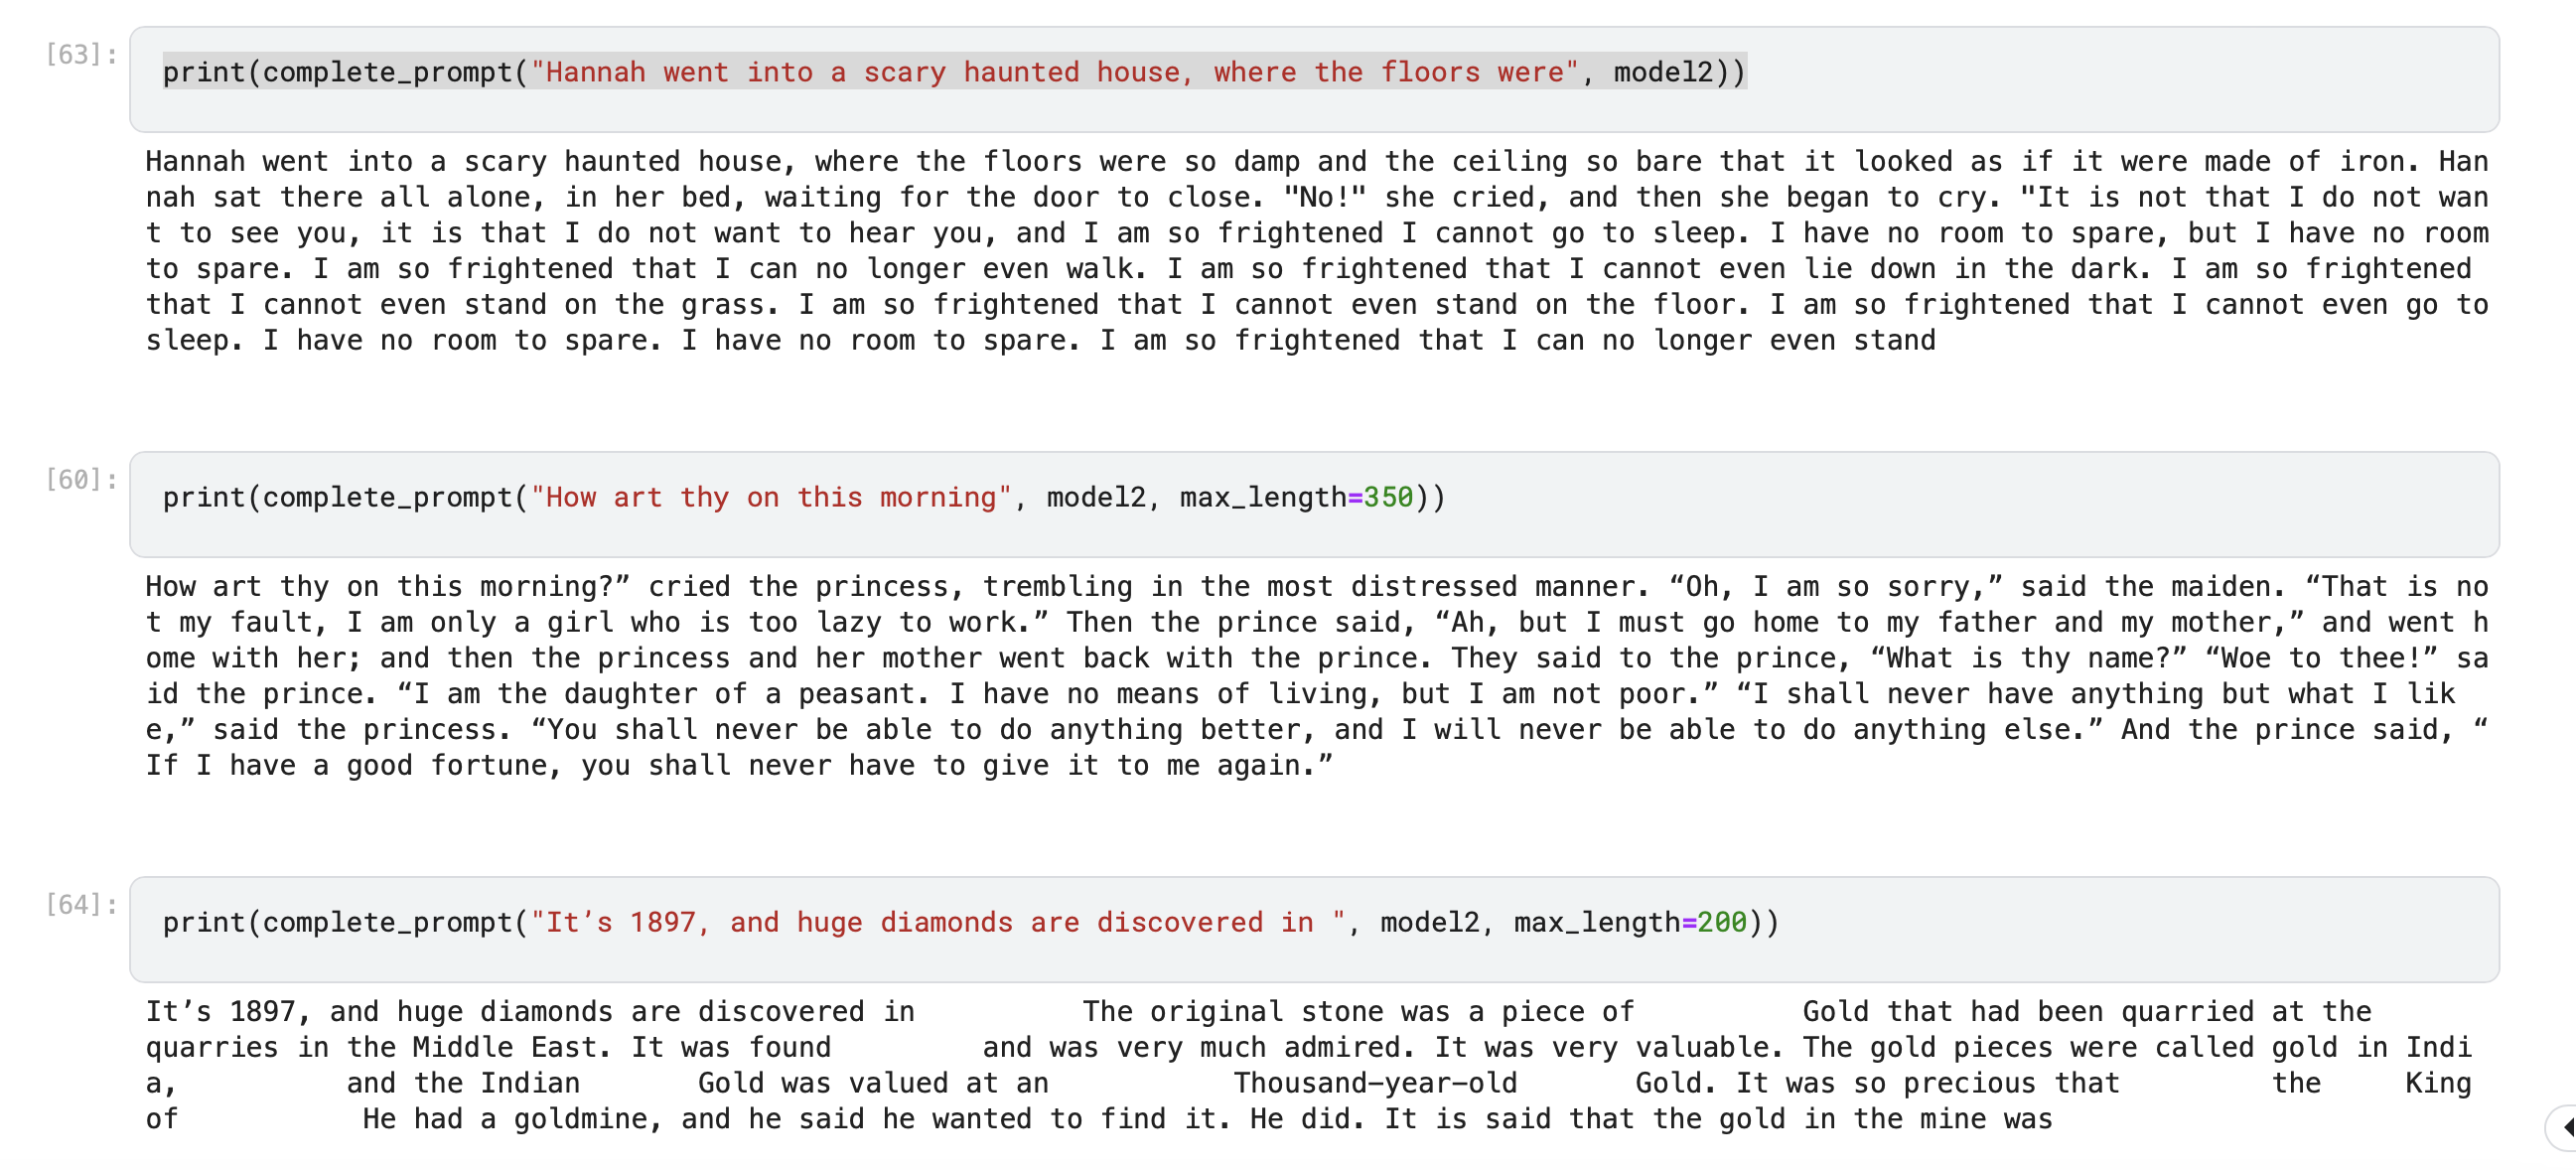